# Fake news detection by Raphaël Faure and Maria Roman

In [ ]:
from google.colab import drive
import os
## Connect your Google Drive with the notebook
drive = drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/GNN-FakeNews')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Modules

In [ ]:
#!pip install --target=/content/drive/MyDrive/colab_packages torch-scatter torch-geometric torch-sparse
import sys #https://colab.research.google.com/drive/1w7kS_C0_EEqIL7092-q6KKvt1F4lLvlS#scrollTo=_Project_Overview_Fake_News_Detection_Using_Graph_Neural_Networks
sys.path.append('/content/drive/MyDrive/colab_packages')


In [ ]:
!pip install -r requirements.txt


In [ ]:
import argparse
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool
from torch_geometric.data import DenseDataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from math import ceil
import os.path as osp
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score,
    precision_score, roc_auc_score, average_precision_score
)
import torch_geometric.transforms as T
import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.utils import to_undirected, add_self_loops
from torch_sparse import coalesce
from torch_geometric.io import read_txt_array
import random
import scipy.sparse as sp

In [ ]:
# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## **Project overview: fake news detection using Graph Neural Networks**

The aim of this project is to replicate and validate the findings from the article *Graph Neural Networks with Continual Learning for Fake News Detection from Social Media* by Yi Han, Shanika Karunasekeran, and Christopher Leckie (2020). This work introduces an innovative approach for detecting fake news without relying on the textual content itself. Instead, their method leverages the **diffusion graph** of news across social media platforms to identify misleading information.

According to the authors, this graph-based approach achieves an impressive accuracy of approximately **80%**, making it a promising alternative to traditional text-based detection methods. Let's break down the key concepts and challenges addressed in the paper.

---

### **1. Understanding fake news: a multifaceted challenge**

Fake news is not a homogeneous phenomenon. It encompasses various types of misleading content, each with distinct propagation patterns:

- **False Context:** true information presented in a misleading context.
- **Imposter Content:** genuine sources impersonated by malicious actors.
- **Fabricated News:** completely false stories with no factual basis.  
- **Manipulated Content:** genuine images or texts altered to deceive.

One of the core challenges in detecting fake news is the **diversity of diffusion patterns**. Two fake news items can spread very differently depending on the topic, target audience, and social platform. This diversity complicates detection and requires adaptive models capable of generalizing across different contexts.

---

### **2. Incremental learning & the catastrophic forgetting problem**

The article tackles an important challenge in real-world deployment: **incremental learning**. In dynamic environments like social media, models must continually adapt to new patterns of misinformation without forgetting previously learned ones. This phenomenon, known as **catastrophic forgetting**, occurs when a model fine-tuned on new data loses its performance on older tasks.

To address this, the authors propose some **continual learning tools**

---

### **3. Critical points & reproducibility issues**

While the approach is promising, several critical points arise when attempting to reproduce the results:

- **No official codebase:** the authors did not provide an implementation, making it challenging to replicate their findings.  
- **Incomplete hyperparameters:** some key details are not provided.  
- **Dataset ambiguity:** although they mention *PolitiFact* and *GossipCop*, the exact graph construction process is not fully documented.

This project aims to **fill this gap** by providing an open-source implementation, fine-tuning hyperparameters, and comparing results across datasets. Our goal is to assess whether the reported performance of **80% accuracy** holds under rigorous, reproducible conditions.

---

**Next step:**  
- Add a KL penalty to prevent catastrophic forgetting.


  

# Data section

## **Data collection and graph construction**

The datasets used in this study come from **FakeNewsNet**, a comprehensive benchmark for fake news detection. This dataset aggregates news articles from two renowned fact-checking platforms:

1. **PolitiFact** ([https://www.politifact.com/](https://www.politifact.com/)): A platform that evaluates the truthfulness of public claims and news articles.  
2. **GossipCop** ([https://www.gossipcop.com/](https://www.gossipcop.com/)): A site specializing in fact-checking celebrity rumors and entertainment news.

The dataset includes news articles along with metadata such as article IDs, publication dates, and truth labels (e.g., *True*, *False*).

To model the spread of news on social media, the authors utilized the **Twitter API** to collect tweets and retweets associated with each article. Each news item is represented as a **diffusion graph**, where:

- **Nodes** represent tweets, including user profiles. A special node is added to represent the news source itself.  
- **Edges** represent relationships between tweets, based on mentions, retweets, and time intervals between posts.

**Adjacency matrices** are constructed by linking tweets to their corresponding retweets, while **node feature matrices** incorporate user profile information, such as:

- whether the user is verified  
- the number of followers and followings  
- the number of lists and favorite tweets
- timestamps indicating when the tweet was posted relative to the first tweet

Thus, each news article is encapsulated within a structured graph representing its propagation pattern on Twitter, enabling detection without analyzing the textual content itself.


## Some usefull functions

In [ ]:
"""
	Functions to help load the graph data
"""

def read_file(folder, name, dtype=None):
	path = osp.join(folder, '{}.txt'.format(name))
	return read_txt_array(path, sep=',', dtype=dtype)


def split(data, batch):
	"""
	PyG util code to create graph batches
	"""

	node_slice = torch.cumsum(torch.from_numpy(np.bincount(batch)), 0)
	node_slice = torch.cat([torch.tensor([0]), node_slice])

	row, _ = data.edge_index
	edge_slice = torch.cumsum(torch.from_numpy(np.bincount(batch[row])), 0)
	edge_slice = torch.cat([torch.tensor([0]), edge_slice])

	# Edge indices should start at zero for every graph
	data.edge_index -= node_slice[batch[row]].unsqueeze(0)
	data.__num_nodes__ = torch.bincount(batch).tolist()

	slices = {'edge_index': edge_slice}
	if data.x is not None:
		slices['x'] = node_slice
	if data.edge_attr is not None:
		slices['edge_attr'] = edge_slice
	if data.y is not None:
		if data.y.size(0) == batch.size(0):
			slices['y'] = node_slice
		else:
			slices['y'] = torch.arange(0, batch[-1] + 2, dtype=torch.long)

	return data, slices


def read_graph_data(folder, feature):
	"""
	PyG util code to create PyG data instance from raw graph data
	"""

	node_attributes = sp.load_npz(folder + f'new_{feature}_feature.npz')
	edge_index = read_file(folder, 'A', torch.long).t()
	node_graph_id = np.load(folder + 'node_graph_id.npy')
	graph_labels = np.load(folder + 'graph_labels.npy')


	edge_attr = None
	x = torch.from_numpy(node_attributes.todense()).to(torch.float)
	node_graph_id = torch.from_numpy(node_graph_id).to(torch.long)
	y = torch.from_numpy(graph_labels).to(torch.long)
	_, y = y.unique(sorted=True, return_inverse=True)

	num_nodes = edge_index.max().item() + 1 if x is None else x.size(0)
	edge_index, edge_attr = add_self_loops(edge_index, edge_attr)
	edge_index, edge_attr = coalesce(edge_index, edge_attr, num_nodes, num_nodes)

	data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
	data, slices = split(data, node_graph_id)

	return data, slices


class ToUndirected:
	def __init__(self):
		"""
		PyG util code to transform the graph to the undirected graph
		"""
		pass

	def __call__(self, data):
		edge_attr = None
		edge_index = to_undirected(data.edge_index, data.x.size(0))
		num_nodes = edge_index.max().item() + 1 if data.x is None else data.x.size(0)
		# edge_index, edge_attr = add_self_loops(edge_index, edge_attr)
		edge_index, edge_attr = coalesce(edge_index, edge_attr, num_nodes, num_nodes)
		data.edge_index = edge_index
		data.edge_attr = edge_attr
		return data


class DropEdge:
	def __init__(self, tddroprate, budroprate):
		"""
		Drop edge operation from BiGCN (Rumor Detection on Social Media with Bi-Directional Graph Convolutional Networks)
		1) Generate TD and BU edge indices
		2) Drop out edges
		Code from https://github.com/TianBian95/BiGCN/blob/master/Process/dataset.py
		"""
		self.tddroprate = tddroprate
		self.budroprate = budroprate

	def __call__(self, data):
		edge_index = data.edge_index

		if self.tddroprate > 0:
			row = list(edge_index[0])
			col = list(edge_index[1])
			length = len(row)
			poslist = random.sample(range(length), int(length * (1 - self.tddroprate)))
			poslist = sorted(poslist)
			row = list(np.array(row)[poslist])
			col = list(np.array(col)[poslist])
			new_edgeindex = [row, col]
		else:
			new_edgeindex = edge_index

		burow = list(edge_index[1])
		bucol = list(edge_index[0])
		if self.budroprate > 0:
			length = len(burow)
			poslist = random.sample(range(length), int(length * (1 - self.budroprate)))
			poslist = sorted(poslist)
			row = list(np.array(burow)[poslist])
			col = list(np.array(bucol)[poslist])
			bunew_edgeindex = [row, col]
		else:
			bunew_edgeindex = [burow, bucol]

		data.edge_index = torch.LongTensor(new_edgeindex)
		data.BU_edge_index = torch.LongTensor(bunew_edgeindex)
		data.root = torch.FloatTensor(data.x[0])
		data.root_index = torch.LongTensor([0])

		return data


class FNNDataset(InMemoryDataset):
	r"""
		The Graph datasets built upon FakeNewsNet data

	Args:
		root (string): Root directory where the dataset should be saved.
		name (string): The name of the dataset.
		transform (callable, optional): A function/transform that takes in an
			:obj:`torch_geometric.data.Data` object and returns a transformed
			version. The data object will be transformed before every access.
			(default: :obj:`None`)
		pre_transform (callable, optional): A function/transform that takes in
			an :obj:`torch_geometric.data.Data` object and returns a
			transformed version. The data object will be transformed before
			being saved to disk. (default: :obj:`None`)
		pre_filter (callable, optional): A function that takes in an
			:obj:`torch_geometric.data.Data` object and returns a boolean
			value, indicating whether the data object should be included in the
			final dataset. (default: :obj:`None`)
	"""

	def __init__(self, root, name, feature='spacy', empty=False, transform=None, pre_transform=None, pre_filter=None):
		self.name = name
		self.root = root
		self.feature = feature
		super(FNNDataset, self).__init__(root, transform, pre_transform, pre_filter)
		if not empty:
			self.data, self.slices, self.train_idx, self.val_idx, self.test_idx = torch.load(self.processed_paths[0])

	@property
	def raw_dir(self):
		name = 'raw/'
		return osp.join(self.root, self.name, name)

	@property
	def processed_dir(self):
		name = 'processed/'
		return osp.join(self.root, self.name, name)

	@property
	def num_node_attributes(self):
		if self.data.x is None:
			return 0
		return self.data.x.size(1)

	@property
	def raw_file_names(self):
		names = ['node_graph_id', 'graph_labels']
		return ['{}.npy'.format(name) for name in names]

	@property
	def processed_file_names(self):
		if self.pre_filter is None:
			return f'{self.name[:3]}_data_{self.feature}.pt'
		else:
			return f'{self.name[:3]}_data_{self.feature}_prefiler.pt'

	def download(self):
		raise NotImplementedError('Must indicate valid location of raw data. No download allowed')

	def process(self):

		self.data, self.slices = read_graph_data(self.raw_dir, self.feature)

		if self.pre_filter is not None:
			data_list = [self.get(idx) for idx in range(len(self))]
			data_list = [data for data in data_list if self.pre_filter(data)]
			self.data, self.slices = self.collate(data_list)

		if self.pre_transform is not None:
			data_list = [self.get(idx) for idx in range(len(self))]
			data_list = [self.pre_transform(data) for data in data_list]
			self.data, self.slices = self.collate(data_list)

		# The fixed data split for benchmarking evaluation
		# train-val-test split is 20%-10%-70%
		self.train_idx = torch.from_numpy(np.load(self.raw_dir + 'train_idx.npy')).to(torch.long)
		self.val_idx = torch.from_numpy(np.load(self.raw_dir + 'val_idx.npy')).to(torch.long)
		self.test_idx = torch.from_numpy(np.load(self.raw_dir + 'test_idx.npy')).to(torch.long)

		torch.save((self.data, self.slices, self.train_idx, self.val_idx, self.test_idx), self.processed_paths[0])

	def __repr__(self):
		return '{}({})'.format(self.name, len(self))

# Model GNN

## GNN Class - How It Works  

This class is a **Graph Neural Network (GNN)** that processes node features and adjacency matrices to learn embeddings.  
It uses **Dense SAGE Convolution (`DenseSAGEConv`)** to propagate information between nodes and extract relevant features.  

### **What It Does**  
- **Passes messages between nodes** using SAGEConv
- **Uses batch normalization** to stabilize training
- **Stacks three convolution layers** to get deeper embeddings
- **Concatenates features** from all layers for richer representations  
- **Optionally applies a linear layer** at the end to refine the output  

Basically, it takes a graph, transforms node features, and learns better representations that can be used for **graph classification, link prediction, or clustering**.


In [ ]:
class GNN(torch.nn.Module):
	def __init__(self, in_channels, hidden_channels, out_channels,
				 normalize=False, lin=True):
		super(GNN, self).__init__()
		self.conv1 = DenseSAGEConv(in_channels, hidden_channels, normalize)
		self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
		self.conv2 = DenseSAGEConv(hidden_channels, hidden_channels, normalize)
		self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
		self.conv3 = DenseSAGEConv(hidden_channels, out_channels, normalize)
		self.bn3 = torch.nn.BatchNorm1d(out_channels)

		if lin is True:
			self.lin = torch.nn.Linear(2 * hidden_channels + out_channels,
									   out_channels)
		else:
			self.lin = None

	def bn(self, i, x):
		batch_size, num_nodes, num_channels = x.size()

		x = x.view(-1, num_channels)
		x = getattr(self, 'bn{}'.format(i))(x)
		x = x.view(batch_size, num_nodes, num_channels)
		return x

	def forward(self, x, adj, mask=None):
		batch_size, num_nodes, in_channels = x.size()

		x0 = x
		x1 = self.bn(1, F.relu(self.conv1(x0, adj, mask)))
		x2 = self.bn(2, F.relu(self.conv2(x1, adj, mask)))
		x3 = self.bn(3, F.relu(self.conv3(x2, adj, mask)))

		x = torch.cat([x1, x2, x3], dim=-1)

		if self.lin is not None:
			x = F.relu(self.lin(x))

		return x

## Net Class - How It Works  

This class is a **hierarchical GNN model** that processes graph data using multiple layers of **Dense SAGE Convolution (`DenseSAGEConv`)** and **Differentiable Pooling (`DiffPool`)**.  
It stacks **three GNN layers** and performs **graph pooling** at different levels to learn structured graph representations.

### **What It Does**  
- **First GNN Layer**: applies **SAGEConv** to node features and learns an initial representation.  
- **Graph Pooling (`DiffPool`)**: reduces the graph size while keeping useful information.  
- **Second GNN Layer**: refines the graph representation at a more abstract level.  
- **Second Pooling Step**: further compresses the graph for hierarchical learning.  
- **Final GNN Layer**: extracts deeper embeddings from the pooled graph.  
- **Fully Connected Layers (`Linear`)**: processes the final embeddings for classification.  
- **Log Softmax Output**: returns probabilities over the class labels.  

Basically, this model **takes a graph, compresses it step by step**, and **outputs a prediction** while keeping track of the hierarchical structure.  
It's great for **graph classification tasks** like **fake news detection, social network analysis, and bioinformatics**.


In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, in_channels, num_classes, dropout_rate=0.5):
        super(Net, self).__init__()

        num_nodes = ceil(0.25 * max_nodes)
        self.gnn1_pool = GNN(in_channels, 64, num_nodes)
        self.gnn1_embed = GNN(in_channels, 64, 64, lin=False)

        num_nodes = ceil(0.25 * num_nodes)
        self.gnn2_pool = GNN(3 * 64, 64, num_nodes)
        self.gnn2_embed = GNN(3 * 64, 64, 64, lin=False)

        self.gnn3_embed = GNN(3 * 64, 64, 64, lin=False)

        self.lin1 = nn.Linear(3 * 64, 64)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.lin2 = nn.Linear(64, num_classes)

    def forward(self, x, adj, mask=None):
        s = self.gnn1_pool(x, adj, mask)
        x = self.gnn1_embed(x, adj, mask)

        x, adj, l1, e1 = dense_diff_pool(x, adj, s, mask)

        s = self.gnn2_pool(x, adj)
        x = self.gnn2_embed(x, adj)

        x, adj, l2, e2 = dense_diff_pool(x, adj, s)

        x = self.gnn3_embed(x, adj)

        x = x.mean(dim=1)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1), l1 + l2, e1 + e2


## Functions for computing and plotting results

In [ ]:
"""
	Utility functions for evaluating the model performance
"""


def eval_deep(log, loader):
	"""
	Evaluating the classification performance given mini-batch data
	"""

	# get the empirical batch_size for each mini-batch
	data_size = len(loader.dataset.indices)
	batch_size = loader.batch_size
	if data_size % batch_size == 0:
		size_list = [batch_size] * (data_size//batch_size)
	else:
		size_list = [batch_size] * (data_size // batch_size) + [data_size % batch_size]

	assert len(log) == len(size_list)

	accuracy, f1_macro, f1_micro, precision, recall = 0, 0, 0, 0, 0

	prob_log, label_log = [], []

	for batch, size in zip(log, size_list):
		pred_y, y = batch[0].data.cpu().numpy().argmax(axis=1), batch[1].data.cpu().numpy().tolist()
		prob_log.extend(batch[0].data.cpu().numpy()[:, 1].tolist())
		label_log.extend(y)

		accuracy += accuracy_score(y, pred_y) * size
		f1_macro += f1_score(y, pred_y, average='macro') * size
		f1_micro += f1_score(y, pred_y, average='micro') * size
		precision += precision_score(y, pred_y, zero_division=0) * size
		recall += recall_score(y, pred_y, zero_division=0) * size

	auc = roc_auc_score(label_log, prob_log)
	ap = average_precision_score(label_log, prob_log)

	return accuracy/data_size, f1_macro/data_size, f1_micro/data_size, precision/data_size, recall/data_size, auc, ap

def plot_test_metrics(results1, label1='Model 1', results2=None, label2='Model 2'):
    """Plot test metrics as a histogram, with optional comparison between two models."""
    metrics = ['Accuracy', 'F1 Macro', 'F1 Micro', 'Precision', 'Recall', 'AUC', 'AP']
    values1 = [results1['accuracy'], results1['f1_macro'], results1['f1_micro'],
               results1['precision'], results1['recall'], results1['auc'], results1['ap']]

    x = np.arange(len(metrics))

    plt.figure(figsize=(14, 8))

    bars1 = plt.bar(x - 0.2, values1, width=0.4, label=label1, color='skyblue')

    if results2:
        values2 = [results2['accuracy'], results2['f1_macro'], results2['f1_micro'],
                   results2['precision'], results2['recall'], results2['auc'], results2['ap']]
        bars2 = plt.bar(x + 0.2, values2, width=0.4, label=label2, color='salmon')

        for bar, value in zip(bars1, values1):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}',
                     ha='center', va='bottom', fontsize=10)

        for bar, value in zip(bars2, values2):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}',
                     ha='center', va='bottom', fontsize=10)
    else:
        for bar, value in zip(bars1, values1):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.4f}',
                     ha='center', va='bottom', fontsize=10)

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'Test Set Metrics: {label1}' + (f' vs {label2}' if results2 else ''))
    plt.xticks(x, metrics)
    plt.ylim(0, 1.1)
    plt.legend(loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Training and testing phase

First let's train our model with the same hyperparameters on both datasets

In [ ]:
def train(train_loader):
    model.train()  # Set the model to training mode
    loss_all = 0  # Accumulator for total loss
    out_log = []  # List to store model outputs and corresponding labels

    for data in train_loader:
        data = data.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        out, _, _ = model(data.x, data.adj, data.mask)

        # Check for NaN or Inf in model output
        if torch.isnan(out).any() or torch.isinf(out).any():
            print("Warning: NaN/Inf detected in model output, skipping batch.")
            continue

        # Store logits (raw model output without softmax)
        out_log.append([out, data.y])

        # Calculate loss (Negative Log Likelihood Loss)
        loss = F.nll_loss(out, data.y.view(-1))

        # Check for NaN or Inf in loss value
        if torch.isnan(loss) or torch.isinf(loss):
            print("Warning: NaN/Inf detected in loss, skipping batch.")
            continue

        # Backpropagation
        loss.backward()  # Compute gradients
        loss_all += data.y.size(0) * loss.item()  # Accumulate loss weighted by batch size
        optimizer.step()  # Update model parameters

    # Normalize the loss by the dataset size and return evaluation metrics
    return eval_deep(out_log, train_loader), loss_all / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()  # Set the model to evaluation mode
    loss_test = 0  # Accumulator for total test loss
    out_log = []  # List to store model outputs and corresponding labels

    for data in loader:
        data = data.to(device)  # Move data to GPU if available

        # Forward pass
        out, _, _ = model(data.x, data.adj, data.mask)

        # Check for NaN or Inf in model output
        if torch.isnan(out).any() or torch.isinf(out).any():
            print("Warning: NaN/Inf detected in model output, skipping batch.")
            continue

        # Store logits converted to probabilities (Softmax for evaluation)
        out_log.append([F.softmax(out, dim=1), data.y])

        # Calculate loss (Negative Log Likelihood Loss)
        loss = F.nll_loss(out, data.y.view(-1))

        # Check for NaN or Inf in loss value
        if torch.isnan(loss) or torch.isinf(loss):
            print("Warning: NaN/Inf detected in loss, skipping batch.")
            continue

        # Accumulate the total loss weighted by the number of samples
        loss_test += data.y.size(0) * loss.item()

    # Normalize the total loss by dataset size and return evaluation metrics
    return eval_deep(out_log, loader), loss_test / len(loader.dataset)


## Politifact


In [ ]:
dataset = FNNDataset(root='data', feature='profile', empty=False, name='politifact',
                     transform=T.ToDense(500), pre_transform=T.ToUndirected())
max_nodes = 500
num_training = int(len(dataset) * 0.6)
num_val = int(len(dataset) * 0.2)
num_test = len(dataset) - (num_training + num_val)

training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])
train_loader = DenseDataLoader(training_set, batch_size=128, shuffle=True)
val_loader = DenseDataLoader(validation_set, batch_size=128, shuffle=False)
test_loader = DenseDataLoader(test_set, batch_size=128, shuffle=False)

/content/drive/MyDrive/colab_packages/torch_geometric/data/dataset.py:240: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(
<ipython-input-5-9da4df61a0b8>:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serial

## Training and testing
We manage to test it on this dataset

Epoch 0: Train Acc=0.5213, Val Acc=0.5161, Train Loss=0.7050356953702075, Val Loss=0.6947700381278992
Epoch 1: Train Acc=0.6862, Val Acc=0.5161, Train Loss=0.649079146537375, Val Loss=0.6962297558784485
Epoch 2: Train Acc=0.7181, Val Acc=0.4032, Train Loss=0.5821462933053362, Val Loss=0.6967597603797913
Epoch 3: Train Acc=0.7766, Val Acc=0.4516, Train Loss=0.5145278319399408, Val Loss=0.6961711049079895
Epoch 4: Train Acc=0.7819, Val Acc=0.4677, Train Loss=0.48635240691773435, Val Loss=0.697130024433136
Epoch 5: Train Acc=0.8085, Val Acc=0.4839, Train Loss=0.43538741735701864, Val Loss=0.7115116119384766
Epoch 6: Train Acc=0.8670, Val Acc=0.4839, Train Loss=0.3936838260356416, Val Loss=0.7429279685020447
Epoch 7: Train Acc=0.8511, Val Acc=0.4839, Train Loss=0.3584785524834978, Val Loss=0.81458580493927
Epoch 8: Train Acc=0.8936, Val Acc=0.4839, Train Loss=0.3079504066325249, Val Loss=0.899945080280304
Epoch 9: Train Acc=0.8883, Val Acc=0.4839, Train Loss=0.2916713337948982, Val Loss=1.

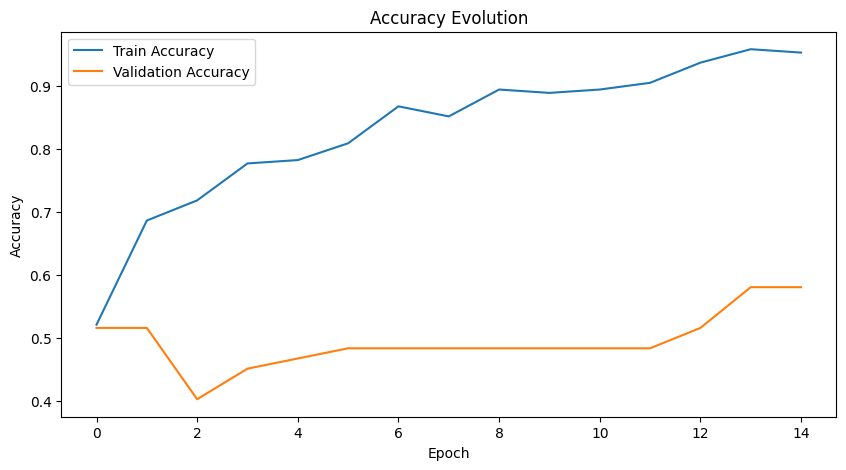

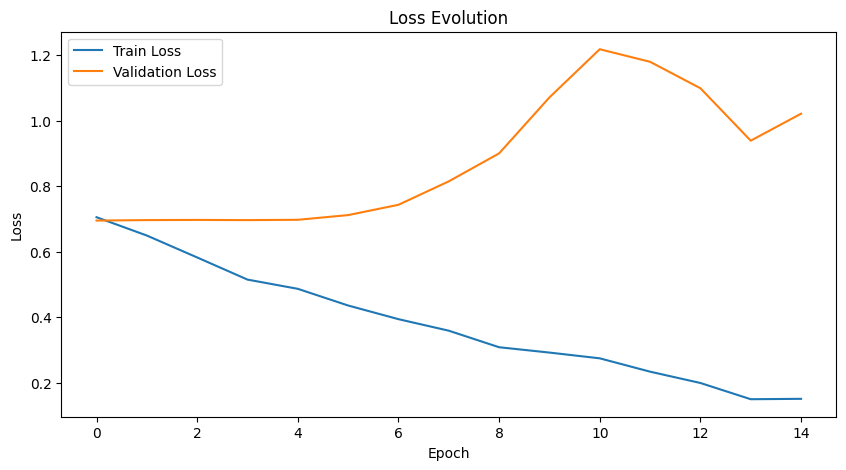

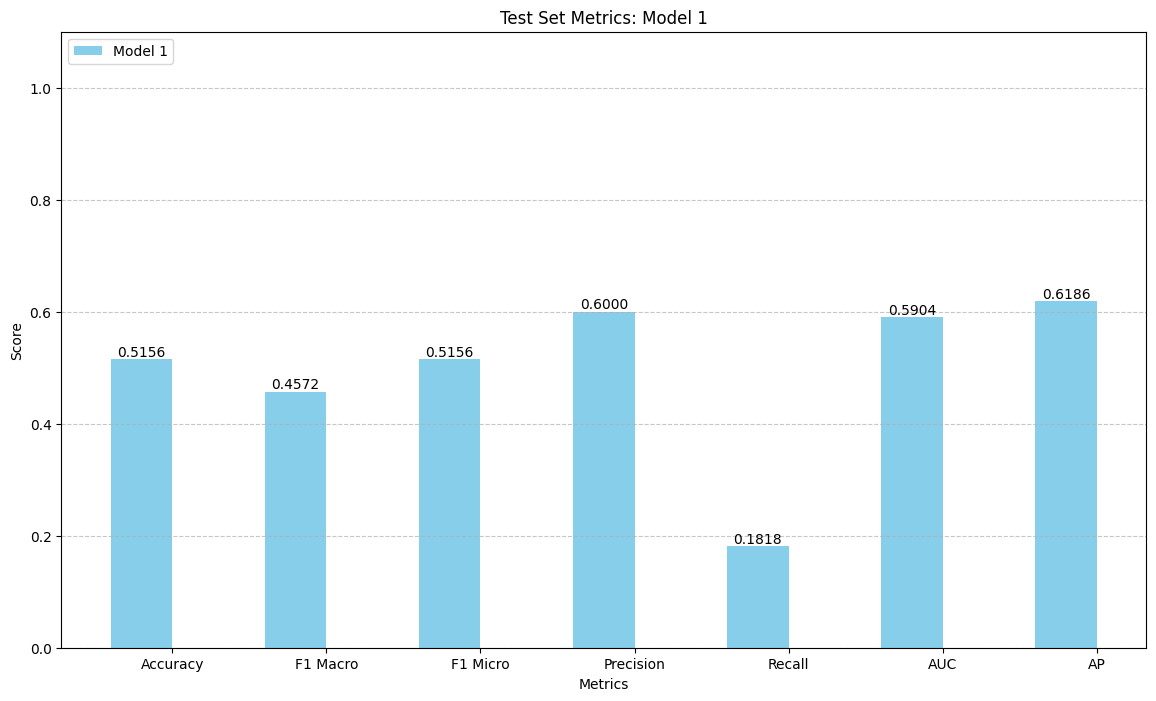

In [ ]:
max_nodes = 500
model = Net(in_channels=dataset.num_features, num_classes=dataset.num_classes, dropout_rate = 0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001


# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []


for epoch in range(15):  # Train for 60 epochs
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train(train_loader)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

    # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)

    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train}, Val Loss={loss_val}')
# Final evaluation on the test set
[acc_test, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = test(test_loader)

# Print final test set results
print("\nFinal Test Set Results:")
print(f'Accuracy: {acc_test:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'F1 Micro: {f1_micro:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'Average Precision (AP): {ap:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Performance visualization
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')
plt.show()

# Store results in a dictionary for easy plotting
test_results = {
    'accuracy': acc_test,
    'f1_macro': f1_macro,
    'f1_micro': f1_micro,
    'precision': precision,
    'recall': recall,
    'auc': auc,
    'ap': ap
}
# Plot metrics
plot_test_metrics(test_results)



### **Addressing Overfitting**

It appears that the model struggles with generalization, showing clear signs of overfitting. To mitigate this issue, we implemented several regularization techniques:

- **Optimizer:** we switched to the **SGD optimizer** for more controlled updates.
- **Weight Decay:** we introduced an **L2 regularization term** via the `weight_decay` parameter.
- **Dropout:** we adjusted the **dropout rate** to **0.3**, striking a balance between preventing co-adaptation and preserving useful features.

These changes aim to improve the model's ability to generalize to unseen data while maintaining stable convergence.


Epoch 0: Train Acc=0.6170, Val Acc=0.4839, Train Loss=0.6710267396683388, Val Loss=0.6951793432235718
Epoch 1: Train Acc=0.6223, Val Acc=0.4839, Train Loss=0.6540201103433649, Val Loss=0.6952284574508667
Epoch 2: Train Acc=0.7287, Val Acc=0.4839, Train Loss=0.6190404295921326, Val Loss=0.6940996050834656
Epoch 3: Train Acc=0.7660, Val Acc=0.4839, Train Loss=0.5898208808391652, Val Loss=0.6919323801994324
Epoch 4: Train Acc=0.8138, Val Acc=0.4839, Train Loss=0.5348996101541722, Val Loss=0.6890810132026672
Epoch 5: Train Acc=0.8564, Val Acc=0.4839, Train Loss=0.4858839683076169, Val Loss=0.6843780875205994
Epoch 6: Train Acc=0.8351, Val Acc=0.4839, Train Loss=0.4455151595967881, Val Loss=0.681129515171051
Epoch 7: Train Acc=0.8670, Val Acc=0.5000, Train Loss=0.4210268182957426, Val Loss=0.6779703497886658
Epoch 8: Train Acc=0.8830, Val Acc=0.4839, Train Loss=0.3720359269608843, Val Loss=0.6777051091194153
Epoch 9: Train Acc=0.8723, Val Acc=0.4839, Train Loss=0.33659074661579536, Val Loss

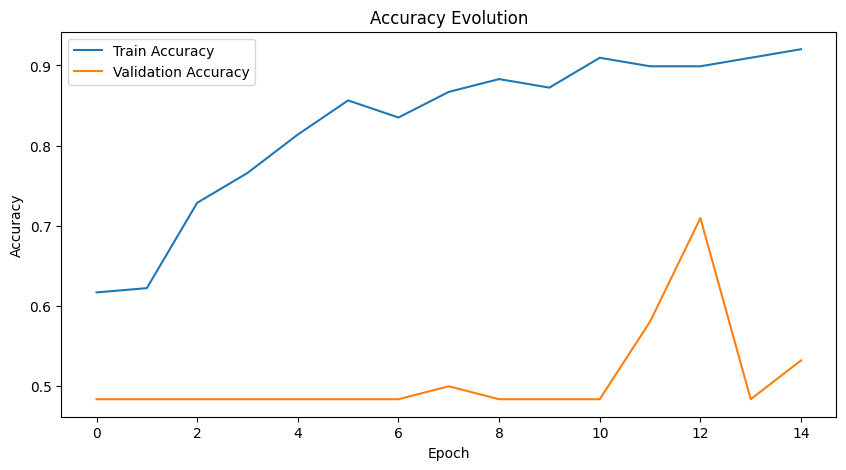

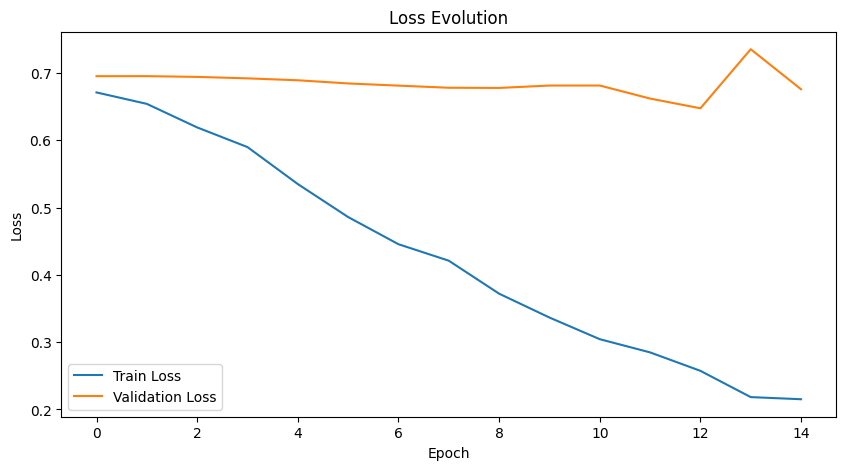

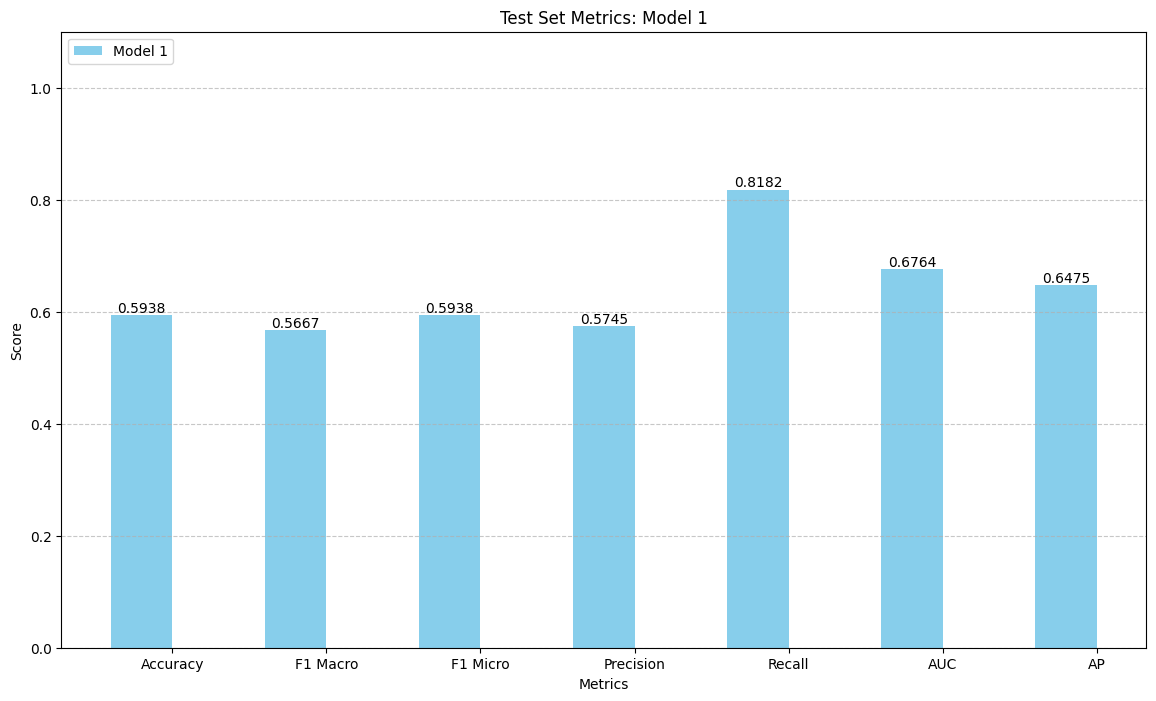

In [ ]:
max_nodes = 300
model = Net(in_channels=dataset.num_features, num_classes=dataset.num_classes, dropout_rate = 0.3).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0001)


# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []


for epoch in range(15):  # Train for 60 epochs
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train(train_loader)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

    # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)

    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train}, Val Loss={loss_val}')
# Final evaluation on the test set
[acc_test, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = test(test_loader)

# Print final test set results
print("\nFinal Test Set Results:")
print(f'Accuracy: {acc_test:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'F1 Micro: {f1_micro:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'Average Precision (AP): {ap:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Performance visualization
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')
plt.show()

# Store results in a dictionary for easy plotting
test_results = {
    'accuracy': acc_test,
    'f1_macro': f1_macro,
    'f1_micro': f1_micro,
    'precision': precision,
    'recall': recall,
    'auc': auc,
    'ap': ap
}
# Plot metrics
plot_test_metrics(test_results)



### **Exploring dataset switching**

Despite applying regularization techniques such as weight decay, dropout, and switching to the SGD optimizer, the model still struggles to generalize and appears to be stuck in a local minimum.

To address this, we hypothesize that introducing a form of **dataset switching** could help the model escape this suboptimal solution. Specifically, we train the model on the **second dataset** (GossipCop) for a few epochs, aiming to perturb the current parameter space. Then, we return to the **original dataset** (PolitiFact), hoping that the intermediate training on a different distribution pushes the model out of the local minimum and leads to better generalization. Let's see first if the model works well on the GossipCop dataset then we will try this method


## Gossipcop


In [ ]:
dataset = FNNDataset(root='data', feature='profile', empty=False, name='gossipcop',
                     transform=T.ToDense(300), pre_transform=T.ToUndirected())
max_nodes = 300
num_training = int(len(dataset) * 0.6)
num_val = int(len(dataset) * 0.2)
num_test = len(dataset) - (num_training + num_val)

training_set, validation_set, test_set = random_split(dataset, [num_training, num_val, num_test])
train_loader = DenseDataLoader(training_set, batch_size=128, shuffle=True)
val_loader = DenseDataLoader(validation_set, batch_size=128, shuffle=False)
test_loader = DenseDataLoader(test_set, batch_size=128, shuffle=False)

<ipython-input-7-3d31c9c5b35a>:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices, self.train_idx, self.val_idx, self.test_idx = torch.load(self.proce

## Training and testing

In [ ]:
dataset.num_features, dataset.num_classes

(10, 2)

Epoch 0: Train Acc=0.8411, Val Acc=0.7399, Train Loss=0.3745, Val Loss=0.5643
Epoch 1: Train Acc=0.9137, Val Acc=0.5339, Train Loss=0.2372, Val Loss=1.0089
Epoch 2: Train Acc=0.9454, Val Acc=0.8352, Train Loss=0.1626, Val Loss=0.3774
Epoch 3: Train Acc=0.9506, Val Acc=0.8800, Train Loss=0.1422, Val Loss=0.3587
Epoch 4: Train Acc=0.9527, Val Acc=0.9524, Train Loss=0.1464, Val Loss=0.1382
Epoch 5: Train Acc=0.9613, Val Acc=0.9588, Train Loss=0.1241, Val Loss=0.2185
Epoch 6: Train Acc=0.9564, Val Acc=0.9588, Train Loss=0.1327, Val Loss=0.1312
Epoch 7: Train Acc=0.9576, Val Acc=0.9048, Train Loss=0.1335, Val Loss=0.2544
Epoch 8: Train Acc=0.9643, Val Acc=0.9524, Train Loss=0.1041, Val Loss=0.1525
Epoch 9: Train Acc=0.9680, Val Acc=0.9350, Train Loss=0.1060, Val Loss=0.1818

Final Test Set Results:
Accuracy: 0.9250
F1 Macro: 0.9244
F1 Micro: 0.9250
Precision: 0.9489
Recall: 0.8963
AUC: 0.9788
Average Precision (AP): 0.9794
Test Loss: 0.2001


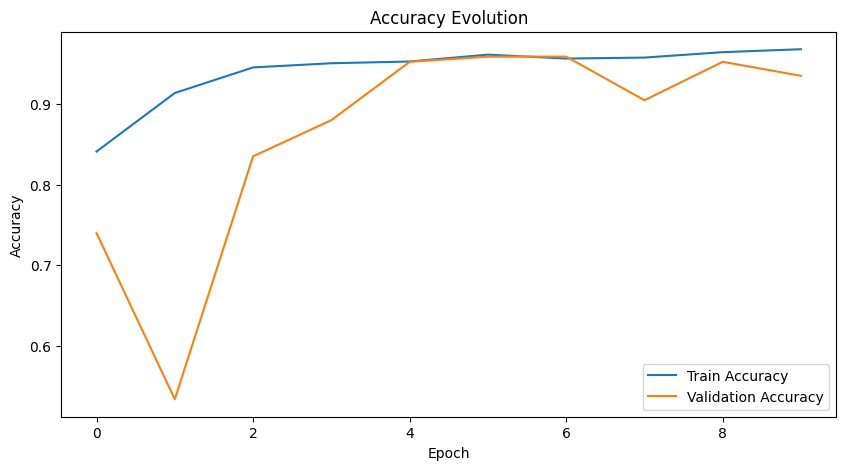

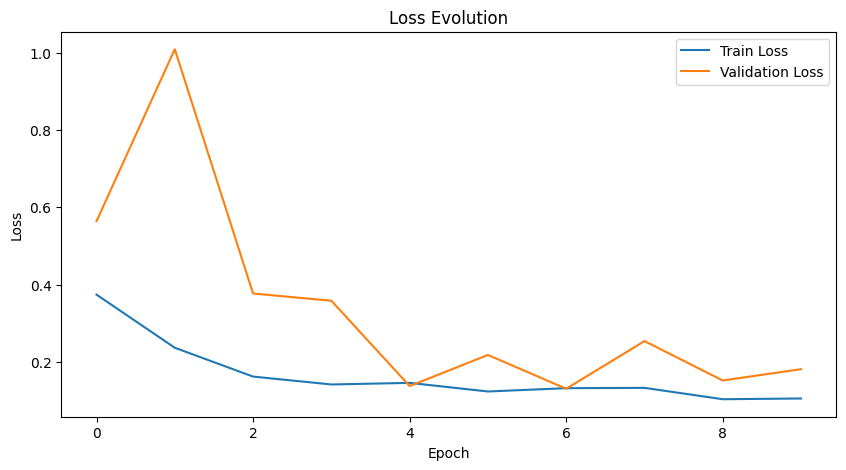

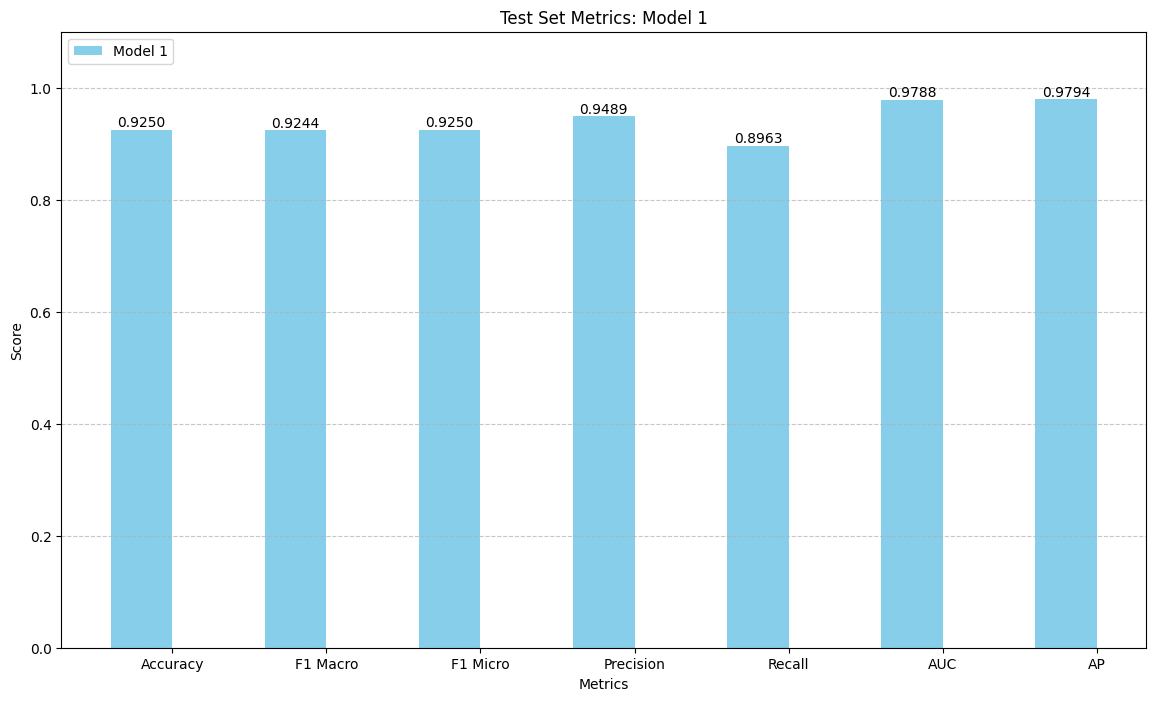

In [ ]:

# Initialize the model and optimizer
model = Net(in_channels=dataset.num_features, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001


# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []

for epoch in range(10):  # Train for 60 epochs
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train(train_loader)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

    # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)

    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train:.4f}, Val Loss={loss_val:.4f}')
# Final evaluation on the test set
[acc_test, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = test(test_loader)

# Print final test set results
print("\nFinal Test Set Results:")
print(f'Accuracy: {acc_test:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'F1 Micro: {f1_micro:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'Average Precision (AP): {ap:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Performance visualization
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')
plt.show()

# Store results in a dictionary for easy plotting
test_results = {
    'accuracy': acc_test,
    'f1_macro': f1_macro,
    'f1_micro': f1_micro,
    'precision': precision,
    'recall': recall,
    'auc': auc,
    'ap': ap
}
# Plot metrics
plot_test_metrics(test_results)


The training results on Gossipcop's dataset are very good. The training loss and the validation loss, are well decreasing over epochs. On top of that, metrics on the test set illustrate a good generalisation. We run many times this code and results are always above 0.85 which is quite better what they got in the article (not the same hyperparameters)

## Initialization witch switching data method



We will now train sequentialy our model on both dataset

In [ ]:
# Load Politifact dataset
dataset_pol = FNNDataset(root='data', feature='profile', empty=False, name='politifact',
                     transform=T.ToDense(500), pre_transform=T.ToUndirected())


# Split dataset into training, validation, and test sets
num_training_pol = int(len(dataset_pol) * 0.6)
num_val_pol = int(len(dataset_pol) * 0.2)
num_test_pol = len(dataset_pol) - (num_training_pol + num_val_pol)

# Create DataLoaders for Politifact
training_set_pol, validation_set_pol, test_set_pol = random_split(dataset_pol, [num_training_pol, num_val_pol, num_test_pol])
train_loader_pol = DenseDataLoader(training_set, batch_size=128, shuffle=True)
val_loader_pol = DenseDataLoader(validation_set, batch_size=128, shuffle=False)
test_loader_pol = DenseDataLoader(test_set, batch_size=128, shuffle=False)



<ipython-input-5-9da4df61a0b8>:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices, self.train_idx, self.val_idx, self.test_idx = torch.load(self.proce

In [ ]:
# Load GossipCop dataset
dataset_gossip = FNNDataset(root='data', feature='profile', empty=False, name='gossipcop',
                            transform=T.ToDense(500), pre_transform=T.ToUndirected())

# Split dataset into training, validation, and test sets
num_training_gossip = int(len(dataset_gossip) * 0.6)
num_val_gossip = int(len(dataset_gossip) * 0.2)
num_test_gossip = len(dataset_gossip) - (num_training_gossip + num_val_gossip)

training_set_gossip, validation_set_gossip, test_set_gossip = random_split(
    dataset_gossip, [num_training_gossip, num_val_gossip, num_test_gossip]
)

# Create DataLoaders for GossipCop
train_loader_gossip = DenseDataLoader(training_set_gossip, batch_size=128, shuffle=True)
val_loader_gossip = DenseDataLoader(validation_set_gossip, batch_size=128, shuffle=False)
test_loader_gossip = DenseDataLoader(test_set_gossip, batch_size=128, shuffle=False)


<ipython-input-5-9da4df61a0b8>:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices, self.train_idx, self.val_idx, self.test_idx = torch.load(self.proce


===== Training on GossipCop Dataset =====
Epoch 0: Train Acc=0.8353, Val Acc=0.5275, Train Loss=0.3956, Val Loss=0.5939
Epoch 1: Train Acc=0.9097, Val Acc=0.7674, Train Loss=0.2473, Val Loss=0.5620

===== Training on PolitiFact Dataset =====
Epoch 0: Train Acc=0.3404, Val Acc=0.6129, Train Loss=2.0804, Val Loss=0.7716
Epoch 1: Train Acc=0.5053, Val Acc=0.5323, Train Loss=1.0805, Val Loss=0.9530
Epoch 2: Train Acc=0.6383, Val Acc=0.5000, Train Loss=0.6691, Val Loss=1.0739
Epoch 3: Train Acc=0.7394, Val Acc=0.5968, Train Loss=0.5467, Val Loss=1.0754
Epoch 4: Train Acc=0.7340, Val Acc=0.5484, Train Loss=0.5366, Val Loss=0.8618
Epoch 5: Train Acc=0.7181, Val Acc=0.5484, Train Loss=0.5191, Val Loss=0.7508
Epoch 6: Train Acc=0.7606, Val Acc=0.5484, Train Loss=0.5010, Val Loss=0.7065
Epoch 7: Train Acc=0.7713, Val Acc=0.5484, Train Loss=0.4905, Val Loss=0.6667
Epoch 8: Train Acc=0.8138, Val Acc=0.5968, Train Loss=0.4625, Val Loss=0.6288
Epoch 9: Train Acc=0.8085, Val Acc=0.6613, Train Loss=0

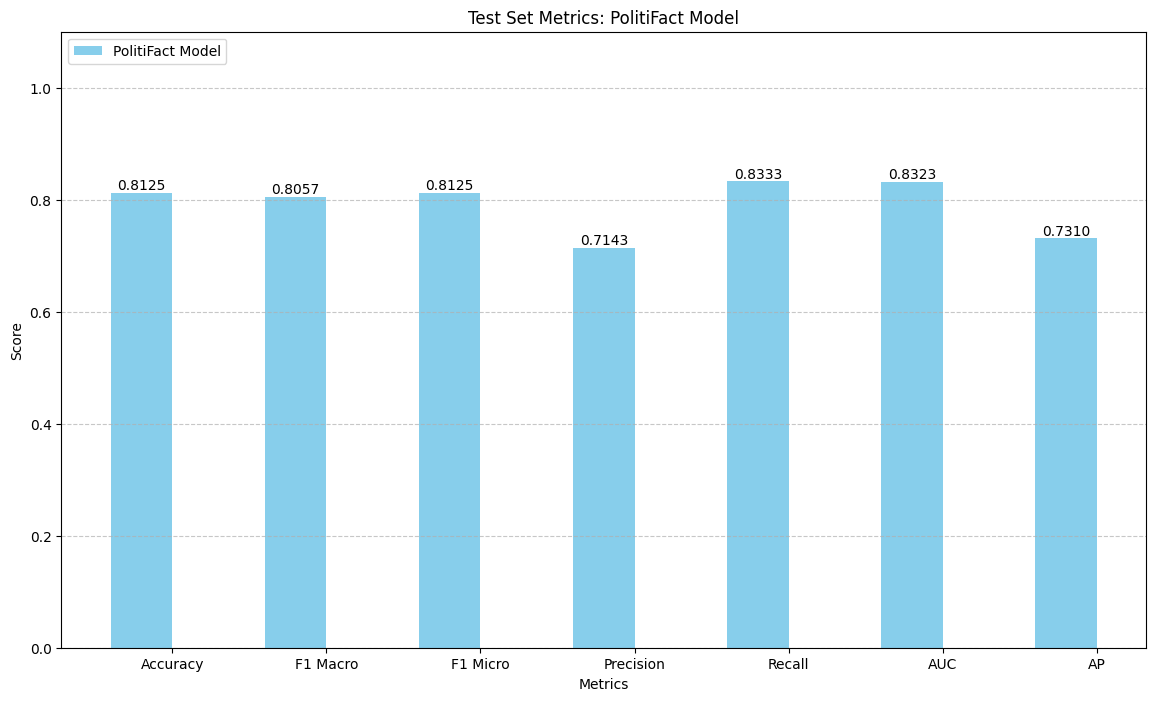

In [ ]:
max_nodes = 300
model = Net(in_channels=dataset.num_features, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001


# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []
train_loader = train_loader_gossip
val_loader = val_loader_gossip
test_loader = test_loader_gossip

print("\n===== Training on GossipCop Dataset =====")
for epoch in range(2):
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train(train_loader)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

    # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)

    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train:.4f}, Val Loss={loss_val:.4f}')

train_loader = train_loader_pol
val_loader = val_loader_pol
test_loader = test_loader_pol

print("\n===== Training on PolitiFact Dataset =====")
for epoch in range(30):  # Train for 10 epochs
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train(train_loader)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

    # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)

    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train:.4f}, Val Loss={loss_val:.4f}')
    if acc_val >=0.85 :
      break
  # Final evaluation on the test set
[acc_test1, f1_macro1, f1_micro1, precision1, recall1, auc1, ap1], test_loss1 = test(test_loader)


# Print final test set results
print("\nFinal Test Set Results:")
print(f'Accuracy: {acc_test1:.4f}')
print(f'F1 Macro: {f1_macro1:.4f}')
print(f'F1 Micro: {f1_micro1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'AUC: {auc1:.4f}')
print(f'Average Precision (AP): {ap1:.4f}')
print(f'Test Loss: {test_loss1:.4f}')

# Store results for PolitiFact (Model 1)
test_results1 = {
    'accuracy': acc_test1,
    'f1_macro': f1_macro1,
    'f1_micro': f1_micro1,
    'precision': precision1,
    'recall': recall1,
    'auc': auc1,
    'ap': ap1
}

plot_test_metrics(test_results1, label1='PolitiFact Model', results2=None, label2='GossipCop Model')

### **Results with the switching method**

The plot above shows the performance metrics of the **PolitiFact Model** after applying the **switching method**, where the model was intermittently trained on both the **GossipCop** and **PolitiFact** datasets. This approach aimed to mitigate overfitting and help the model generalize better by escaping local minima.


The **switching method** helped stabilize the model's performance, improving generalization and reducing overfitting. However, the imbalance between precision and recall suggests further tuning may be beneficial.


# Incremental learning

## Without penalisation

### Politifact then Gossipcop

Epoch 0: Train Acc=0.5585, Val Acc=0.4839, Train Loss=0.6907, Val Loss=0.6954
Epoch 1: Train Acc=0.7287, Val Acc=0.4839, Train Loss=0.5989, Val Loss=0.6934
Epoch 2: Train Acc=0.7553, Val Acc=0.4839, Train Loss=0.5358, Val Loss=0.6910
Epoch 3: Train Acc=0.8138, Val Acc=0.4839, Train Loss=0.4695, Val Loss=0.6897
Epoch 4: Train Acc=0.8404, Val Acc=0.5323, Train Loss=0.4043, Val Loss=0.6851
Epoch 5: Train Acc=0.8457, Val Acc=0.5645, Train Loss=0.3696, Val Loss=0.6859
Epoch 6: Train Acc=0.8617, Val Acc=0.3710, Train Loss=0.3387, Val Loss=0.7127
Epoch 7: Train Acc=0.8777, Val Acc=0.4677, Train Loss=0.2962, Val Loss=0.7404
Epoch 8: Train Acc=0.9043, Val Acc=0.4032, Train Loss=0.2488, Val Loss=0.7747
Epoch 9: Train Acc=0.9096, Val Acc=0.5161, Train Loss=0.2397, Val Loss=0.9322

Final Test Set Results:
Accuracy: 0.4062
F1 Macro: 0.3091
F1 Micro: 0.4062
Precision: 1.0000
Recall: 0.0256
AUC: 0.5754
Average Precision (AP): 0.6622
Test Loss: 0.9735
Epoch 0: Train Acc=0.7947, Val Acc=0.7582, Train L

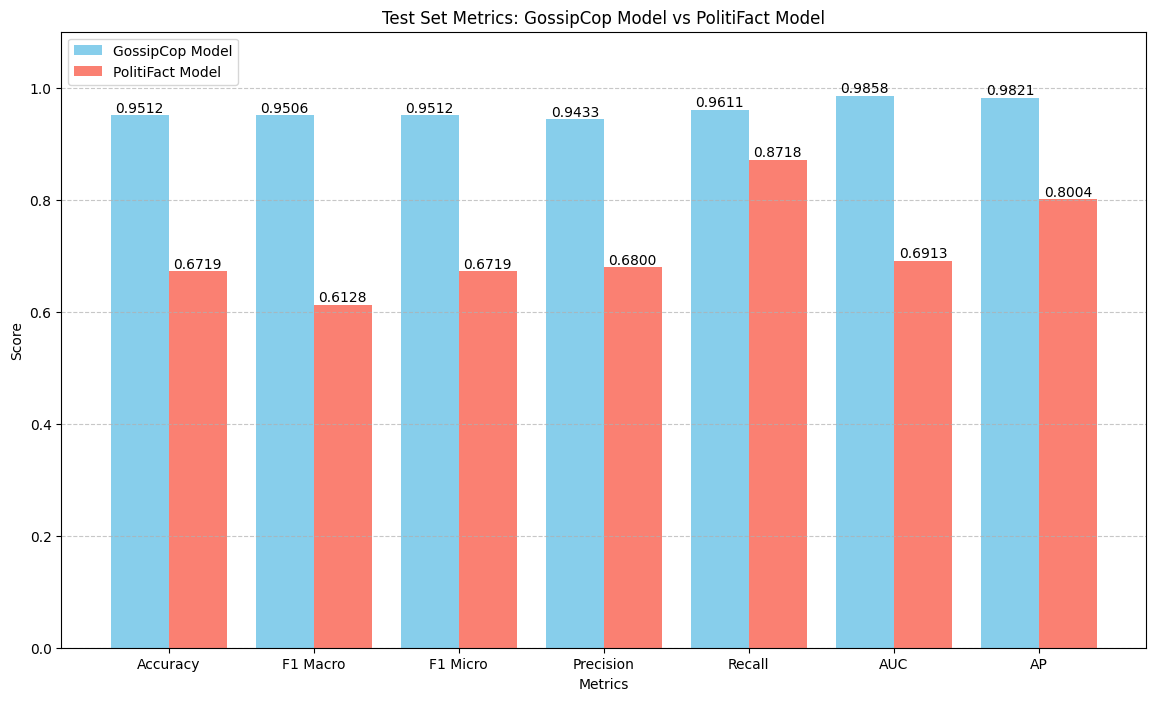

In [ ]:
max_nodes = 300
model = Net(in_channels=dataset.num_features, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001


# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []
train_loader = train_loader_pol
val_loader = val_loader_pol
test_loader = test_loader_pol

for epoch in range(10):  # Train for 10 epochs
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train(train_loader)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

    # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)

    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train:.4f}, Val Loss={loss_val:.4f}')
# Final evaluation on the test set
[acc_test, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = test(test_loader)
# Print final test set results
print("\nFinal Test Set Results:")
print(f'Accuracy: {acc_test:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'F1 Micro: {f1_micro:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'Average Precision (AP): {ap:.4f}')
print(f'Test Loss: {test_loss:.4f}')

train_loader = train_loader_gossip
val_loader = val_loader_gossip
test_loader = test_loader_gossip


for epoch in range(10):  # Train for 10 epochs
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train(train_loader)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

    # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)

    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train:.4f}, Val Loss={loss_val:.4f}')
# Final evaluation on the test set
[acc_test1, f1_macro1, f1_micro1, precision1, recall1, auc1, ap1], test_loss1 = test(test_loader)


# Print final test set results
print("\nFinal Test Set Results:")
print(f'Accuracy: {acc_test1:.4f}')
print(f'F1 Macro: {f1_macro1:.4f}')
print(f'F1 Micro: {f1_micro1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'AUC: {auc1:.4f}')
print(f'Average Precision (AP): {ap1:.4f}')
print(f'Test Loss: {test_loss1:.4f}')

# Évaluation sur un second modèle
[acc_test2, f1_macro2, f1_micro2, precision2, recall2, auc2, ap2], test_loss2 = test(test_loader_pol)


# Print final test set results
print("\nFinal Test Set Results:")
print(f'Accuracy: {acc_test2:.4f}')
print(f'F1 Macro: {f1_macro2:.4f}')
print(f'F1 Micro: {f1_micro2:.4f}')
print(f'Precision: {precision2:.4f}')
print(f'Recall: {recall2:.4f}')
print(f'AUC: {auc2:.4f}')
print(f'Average Precision (AP): {ap2:.4f}')
print(f'Test Loss: {test_loss2:.4f}')



# Store results for Model 1
test_results1 = {
    'accuracy': acc_test1,
    'f1_macro': f1_macro1,
    'f1_micro': f1_micro1,
    'precision': precision1,
    'recall': recall1,
    'auc': auc1,
    'ap': ap1
}


# Store results for Model 2
test_results2 = {
    'accuracy': acc_test2,
    'f1_macro': f1_macro2,
    'f1_micro': f1_micro2,
    'precision': precision2,
    'recall': recall2,
    'auc': auc2,
    'ap': ap2
}

# Plot comparison between Model 1 and Model 2
plot_test_metrics(test_results1, label1='GossipCop Model', results2=test_results2, label2='PolitiFact Model')


As we have seen previously, without using the switching dataset method for initialization, the training phase on the PolitiFact dataset is not effective, making this example irrelevant.

### Gossipcop then Politifact



===== Training on GossipCop Dataset =====
Epoch 0: Train Acc=0.8487, Val Acc=0.7747, Train Loss=0.3626, Val Loss=0.4922
Epoch 1: Train Acc=0.9039, Val Acc=0.8187, Train Loss=0.2559, Val Loss=0.3967
Epoch 2: Train Acc=0.9314, Val Acc=0.8187, Train Loss=0.1967, Val Loss=0.3867
Epoch 3: Train Acc=0.9362, Val Acc=0.9231, Train Loss=0.1928, Val Loss=0.2264
Epoch 4: Train Acc=0.9484, Val Acc=0.9487, Train Loss=0.1673, Val Loss=0.1524
Epoch 5: Train Acc=0.9478, Val Acc=0.9524, Train Loss=0.1510, Val Loss=0.1453
Epoch 6: Train Acc=0.9573, Val Acc=0.9359, Train Loss=0.1353, Val Loss=0.2077
Epoch 7: Train Acc=0.9597, Val Acc=0.9451, Train Loss=0.1327, Val Loss=0.1749
Epoch 8: Train Acc=0.9631, Val Acc=0.9524, Train Loss=0.1243, Val Loss=0.1806
Epoch 9: Train Acc=0.9649, Val Acc=0.9432, Train Loss=0.1150, Val Loss=0.1799

===== Final Test Set Results on GossipCop =====
Accuracy: 0.9421
F1 Macro: 0.9416
F1 Micro: 0.9421
Precision: 0.9466
Recall: 0.9372
AUC: 0.9774
Average Precision (AP): 0.9678
T

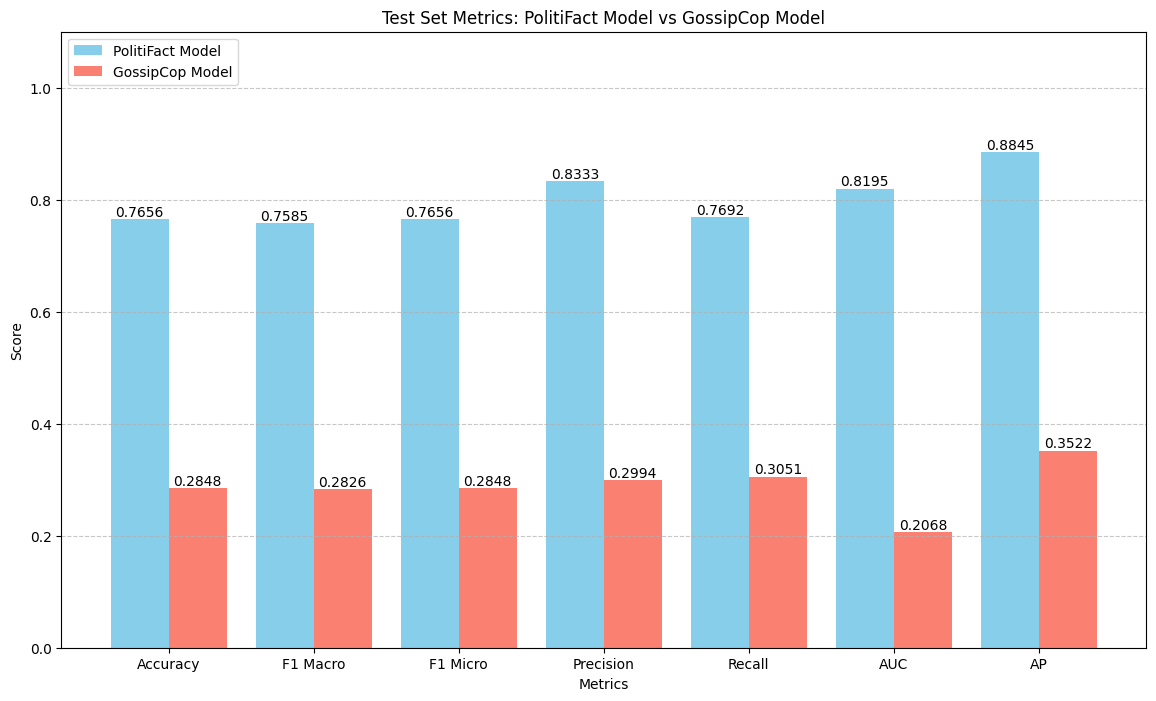

In [ ]:
max_nodes = 300

# Train on GossipCop first
model = Net(in_channels=dataset_gossip.num_features, num_classes=dataset_gossip.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []
train_loader = train_loader_gossip
val_loader = val_loader_gossip
test_loader = test_loader_gossip

print("\n===== Training on GossipCop Dataset =====")
for epoch in range(10):  # Train for 10 epochs
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train(train_loader)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

    # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)

    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train:.4f}, Val Loss={loss_val:.4f}')

# Final evaluation on the GossipCop test set
[acc_test, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = test(test_loader)

print("\n===== Final Test Set Results on GossipCop =====")
print(f'Accuracy: {acc_test:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'F1 Micro: {f1_micro:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'Average Precision (AP): {ap:.4f}')
print(f'Test Loss: {test_loss:.4f}')



train_loader = train_loader_pol
val_loader = val_loader_pol
test_loader = test_loader_pol

print("\n===== Training on PolitiFact Dataset =====")
for epoch in range(20):  # Train for 10 epochs
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train(train_loader)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

    # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)

    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train:.4f}, Val Loss={loss_val:.4f}')

# Final evaluation on the test set for PolitiFact
[acc_test1, f1_macro1, f1_micro1, precision1, recall1, auc1, ap1], test_loss1 = test(test_loader_pol)

# Print final test set results for PolitiFact
print("\nFinal Test Set Results (PolitiFact):")
print(f'Accuracy: {acc_test1:.4f}')
print(f'F1 Macro: {f1_macro1:.4f}')
print(f'F1 Micro: {f1_micro1:.4f}')
print(f'Precision: {precision1:.4f}')
print(f'Recall: {recall1:.4f}')
print(f'AUC: {auc1:.4f}')
print(f'Average Precision (AP): {ap1:.4f}')
print(f'Test Loss: {test_loss1:.4f}')

# Évaluation sur un second modèle (GossipCop)
[acc_test2, f1_macro2, f1_micro2, precision2, recall2, auc2, ap2], test_loss2 = test(test_loader_gossip)

# Print final test set results for GossipCop
print("\nFinal Test Set Results (GossipCop):")
print(f'Accuracy: {acc_test2:.4f}')
print(f'F1 Macro: {f1_macro2:.4f}')
print(f'F1 Micro: {f1_micro2:.4f}')
print(f'Precision: {precision2:.4f}')
print(f'Recall: {recall2:.4f}')
print(f'AUC: {auc2:.4f}')
print(f'Average Precision (AP): {ap2:.4f}')
print(f'Test Loss: {test_loss2:.4f}')

# Store results for PolitiFact (Model 1)
test_results1 = {
    'accuracy': acc_test1,
    'f1_macro': f1_macro1,
    'f1_micro': f1_micro1,
    'precision': precision1,
    'recall': recall1,
    'auc': auc1,
    'ap': ap1
}

# Store results for GossipCop (Model 2)
test_results2 = {
    'accuracy': acc_test2,
    'f1_macro': f1_macro2,
    'f1_micro': f1_micro2,
    'precision': precision2,
    'recall': recall2,
    'auc': auc2,
    'ap': ap2
}

# Plot comparison between PolitiFact and GossipCop
plot_test_metrics(test_results1, label1='PolitiFact Model', results2=test_results2, label2='GossipCop Model')


The graph above illustrates the phenomenon of **catastrophic forgetting**, as highlighted in the original paper. While the model initially performs well on the **GossipCop** dataset, its performance significantly deteriorates when evaluated on the **PolitiFact** dataset after training on the former. This drastic drop in metrics demonstrates how the model forgets previously learned information when exposed to new data.

## With the DKL penalty

The idea behind the KL divergence penalty is pretty straightforward: **avoid catastrophic forgetting** when switching datasets. Normally, when you fine-tune a model on a new dataset, it tends to overwrite what it learned before. This means performance on the old task drops significantly, which is exactly what we’re trying to prevent.

Here’s the approach:  
1. While training on **GossipCop**, we store the model’s output logits (pre-softmax) for a subset of old samples.  
2. When we switch to **PolitiFact**, we occasionally reintroduce those GossipCop samples. For each batch, we compute the **KL divergence** between the current predictions and the stored logits from the previous training.  
3. This divergence becomes a **penalty term** added to the task-specific loss, pushing the model to avoid drifting too far from its previous output distribution.

The goal here isn’t to freeze the model but to **strike a balance** between learning new patterns and retaining past knowledge. It’s like giving the model a gentle reminder: *“Hey, don’t forget what you already knew.”* This approach, inspired by continual learning strategies like **Elastic Weight Consolidation (EWC)**, works directly at the **output level**, making sure the decision boundaries stay stable while the model adapts to new data.

In [ ]:
import torch.nn.functional as F

def kl_divergence_loss(logits_new, logits_old):
    """ Compute KL Divergence loss between new and old model outputs. """
    prob_new = F.softmax(logits_new, dim=-1)  # Convert logits to probabilities
    log_prob_old = F.log_softmax(logits_old, dim=-1)  # Ensure log probabilities

    return F.kl_div(log_prob_old, prob_new, reduction='batchmean')


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch

class OldDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


def collate_fn(batch):
    batch = Batch.from_data_list(batch)
    batch.x = batch.x.view(-1, 500, 10)  # 500 nœuds, 10 features
    batch.adj = batch.adj.view(-1, 500, 500)  # Matrice d'adjacence carrée
    batch.mask = batch.mask.view(-1, 500)  # Masque par nœud
    return batch


def sample_old_data(dataset, size=500, batch_size=128):
    indices = torch.randperm(len(dataset))[:size]  # Échantillons aléatoires
    sampled_data = [dataset[i] for i in indices]
    old_dataset = OldDataset(sampled_data)
    return old_dataset




def collect_reference_outputs(model, old_loader, sample_size=500):
    """Collect reference logits for a sample of old data."""
    model.eval()
    ref_outputs = {}

    with torch.no_grad():
        for data in old_loader:
            data = data.to(device)
            out, _, _ = model(data.x, data.adj, data.mask)

            # Stocker les logits par échantillon avec leur index unique
            for i, label in enumerate(data.y):
                ref_outputs[f'batch_{i}_label_{label.item()}'] = out[i].detach().cpu()

    return ref_outputs

class LabeledDataset(Dataset):
    """Wrapper to label datasets with their source ('new' or 'old')."""
    def __init__(self, dataset, source):
        self.dataset = dataset
        self.source = source

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        data.source = self.source  # Ajout d'un attribut source
        return data

# Créer les datasets labellisés
old_dataset = sample_old_data(training_set_gossip, size=200, batch_size=128)
old_labeled = LabeledDataset(old_dataset, 'old')
new_labeled = LabeledDataset(training_set_pol, 'new')

# Fusion des datasets avec DataLoader
merged_dataset = torch.utils.data.ConcatDataset([old_labeled, new_labeled])
merged_loader = DataLoader(merged_dataset, batch_size=128, shuffle=True)


In [ ]:
old_loader = DataLoader(old_dataset, batch_size=128, shuffle=True, drop_last=True, collate_fn=collate_fn)

In [ ]:
lambda_kl = 0.01
taille_old = 200

In [ ]:
def train_with_kl(train_loader, ref_outputs):
    model.train()
    loss_all = 0
    out_log = []

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        out, _, _ = model(data.x, data.adj, data.mask)
        loss_task = F.nll_loss(out, data.y.view(-1))

        # Si batch = ancien dataset, appliquer la pénalité KL
        loss_kl = 0
        if hasattr(data, 'source') and data.source == 'old':
            if data.y.item() in ref_outputs:
                old_output = ref_outputs[data.y.item()].to(device)
                loss_kl = F.kl_div(F.log_softmax(out, dim=-1), F.softmax(old_output, dim=-1), reduction='batchmean')

        # Loss totale
        lambda_kl = 0.1
        loss = loss_task + lambda_kl * loss_kl

        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()

        out_log.append([F.softmax(out, dim=1), data.y])

    return eval_deep(out_log, train_loader), loss_all / len(train_loader.dataset)



In [ ]:
max_nodes = 300

# Train on GossipCop first
model = Net(in_channels=dataset_gossip.num_features, num_classes=dataset_gossip.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []
train_loader = train_loader_gossip
val_loader = val_loader_gossip
test_loader = test_loader_gossip
D_old = []
print("\n===== Training on GossipCop Dataset =====")
for epoch in range(10):  # Train for 10 epochs
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train(train_loader)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

    # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)

    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train:.4f}, Val Loss={loss_val:.4f}')
    if acc_val >= 0.95 : break
# Final evaluation on the GossipCop test set
[acc_test, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = test(test_loader)

print("\n===== Final Test Set Results on GossipCop =====")
print(f'Accuracy: {acc_test:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'F1 Micro: {f1_micro:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'Average Precision (AP): {ap:.4f}')
print(f'Test Loss: {test_loss:.4f}')




===== Training on GossipCop Dataset =====
Epoch 0: Train Acc=0.8292, Val Acc=0.7747, Train Loss=0.3969, Val Loss=0.5408
Epoch 1: Train Acc=0.9155, Val Acc=0.7610, Train Loss=0.2212, Val Loss=0.6611
Epoch 2: Train Acc=0.9350, Val Acc=0.8452, Train Loss=0.1818, Val Loss=0.4586
Epoch 3: Train Acc=0.9481, Val Acc=0.9588, Train Loss=0.1553, Val Loss=0.1513

===== Final Test Set Results on GossipCop =====
Accuracy: 0.9479
F1 Macro: 0.9476
F1 Micro: 0.9479
Precision: 0.9309
Recall: 0.9647
AUC: 0.9857
Average Precision (AP): 0.9842
Test Loss: 0.1513


In [ ]:
# Stocker une mémoire des anciens échantillons
D_old_loader = old_loader
train_loader = merged_loader
val_loader = val_loader_pol
test_loader = test_loader_pol

In [ ]:
# Debugging print for old_loader
print("Old loader's data:")
for data in old_loader:
  print("Data shape:", data.x.shape)
  print("Data size:", data.x.size())
  print("Data adj shape:", data.adj.shape)
  print("Data mask shape:", data.mask.shape if data.mask is not None else "None")


Old loader's data:
Data shape: torch.Size([128, 500, 10])
Data size: torch.Size([128, 500, 10])
Data adj shape: torch.Size([128, 500, 500])
Data mask shape: torch.Size([128, 500])


In [ ]:
ref_outputs = collect_reference_outputs(model, D_old_loader)

In [ ]:
# Entraînement avec le DataLoader D_old

print("\n===== Training on PolitiFact Dataset =====")
for epoch in range(10):
    [acc_train, _, _, _, recall_train, auc_train, _], loss_train = train_with_kl(train_loader, ref_outputs)
    [acc_val, _, _, _, recall_val, auc_val, _], loss_val = test(val_loader)

        # Store results for visualization
    train_acc.append(acc_train)
    val_acc.append(acc_val)
    train_loss.append(loss_train)
    val_loss.append(loss_val)
    if acc_val >= 0.95 : break
    # Print training progress
    print(f'Epoch {epoch}: Train Acc={acc_train:.4f}, Val Acc={acc_val:.4f}, Train Loss={loss_train:.4f}, Val Loss={loss_val:.4f}')



# Final evaluation on the PolitiFact test set
[acc_test, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = test(test_loader)

print("\n===== Final Test Set Results on PolitiFact =====")
print(f'Accuracy: {acc_test:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'F1 Micro: {f1_micro:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'Average Precision (AP): {ap:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Final evaluation: Test PolitiFact model on GossipCop
[acc_test, f1_macro, f1_micro, precision, recall, auc, ap], test_loss = test(test_loader_gossip)

print("\n===== PolitiFact Model Tested on GossipCop =====")
print(f'Accuracy: {acc_test:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'F1 Micro: {f1_micro:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUC: {auc:.4f}')
print(f'Average Precision (AP): {ap:.4f}')
print(f'Test Loss: {test_loss:.4f}')



===== Training on PolitiFact Dataset =====


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'torch_geometric.data.data.Data'>

The error TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'torch_geometric.data.data.Data'> occurs because PyTorch's default collate_fn cannot properly batch PyTorch Geometric Data objects.